# MODELO DE ÁRBOL DE DECISIÓN

librerías necesarias para la implementación del modelo de árbol de decisión y la visualización de los resultados obtenidos.

In [92]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_validate
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, make_scorer, f1_score, recall_score, roc_curve, auc

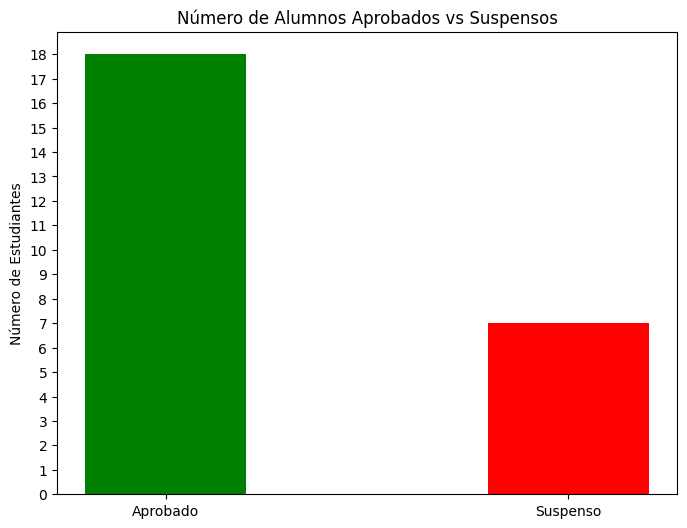

In [93]:
#Carga de los archivos para train y test. Utilizaré los datos de las clases 96, 89 y 81 para entrenar el modelo y para probar el modelo utilizaré los datos de la clase 84
train_data = pd.read_excel('train.xlsx')
test_data = pd.read_excel('test.xlsx')

#Visualización de los datos del dataset "test"
#Primero contamos los alumnos aprobados y los alumnos suspensos
aprobados = test_data[test_data['nota_final_aprobado'] == 'SI'].shape[0]
suspensos = test_data[test_data['nota_final_aprobado'] == 'NO'].shape[0]

#Creación del gráfico de barras para la visualización de los datos
plt.figure(figsize=(8, 6))
max_value = max(aprobados, suspensos)
plt.yticks(range(0, max_value + 1))
plt.bar('Aprobado', aprobados, width=0.4, color='green')
plt.bar('Suspenso', suspensos, width=0.4, color='red')
plt.title('Número de Alumnos Aprobados vs Suspensos')
plt.ylabel('Número de Estudiantes')
plt.show()

In [94]:
#Visualización de los datos
train_data.head()

,login_est,created,submitted,uploaded,viewed,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,diferencia_dias_week1,accesos_week1,wooclap_average,nota_final_aprobado
0,1,0,0,0,9,1,0,1,5,2,0,0,-1,4,-1,NO
1,2,0,0,0,5,0,0,0,2,3,0,0,-1,3,-1,SI
2,3,1,1,1,27,2,0,0,18,10,0,0,2,3,-1,SI
3,4,1,1,1,25,0,0,0,21,0,5,2,-1,-1,-1,SI
4,5,1,1,1,77,1,0,0,73,6,0,0,-1,3,-1,SI


In [95]:
#Definimos las variables independientes X de la variable objetivo Y que será la variable 'nota_final_aprobado' de cada dataframe
encoder = LabelEncoder()
train_data['nota_final_aprobado'] = encoder.fit_transform(train_data['nota_final_aprobado'])
test_data['nota_final_aprobado'] = encoder.transform(test_data['nota_final_aprobado'])
X_train = train_data.drop('nota_final_aprobado', axis=1)
y_train = train_data['nota_final_aprobado']
X_test = test_data.drop('nota_final_aprobado', axis=1)
y_test = test_data['nota_final_aprobado']

#Se definen las diferentes configuraciones de la variable 'class_weights' para la ejecución de la validación cruzada
class_weights = [None, 'balanced', {0: 2, 1: 1}, {0: 3, 1: 1}]

#Se crea un scorer que usa el f1-score para medir el desempeño del modelo utilizando la validación cruzada.
scorer = make_scorer(f1_score)

#Se ejecuta la validacion cruzada con los diferentes class_weight para evaluar qué ponderación es más consistente
results = []
for cw in class_weights:
    decision_tree = DecisionTreeClassifier(class_weight=cw, max_depth=5, criterion='entropy', min_samples_leaf=5, min_samples_split=2)
    cv_results = cross_validate(decision_tree, X_train, y_train, cv=5, scoring=scorer)
    results.append(cv_results['test_score'])

results

[array([0.        , 0.76923077, 0.58823529, 0.7804878 , 0.74285714]),
 array([0.        , 0.6       , 0.46153846, 0.33333333, 0.51851852]),
 array([0.        , 0.6       , 0.46153846, 0.33333333, 0.51851852]),
 array([0.36363636, 0.28571429, 0.46153846, 0.51851852, 0.51851852])]

In [96]:
#Se entrena el modelo con la ponderación de clase None y se evalua el modelo en el conjunto de prueba
decision_tree = DecisionTreeClassifier(class_weight=None, max_depth=5, criterion='gini', min_samples_leaf=5, min_samples_split=2)
decision_tree.fit(X_train, y_train)
y_pred = decision_tree.predict(X_test)

#Se imprime en pantalla el f1-score, accuracy, recall y el classification report
accuracy = accuracy_score(y_test, y_pred)
score = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred, output_dict=False)
print("Accuracy:", accuracy)
print("F1-Score:", score)
print("Recall:", recall)
print("Classification Report\n", class_report)

Accuracy: 0.76
F1-Score: 0.8571428571428571
Recall: 1.0
Classification Report
               precision    recall  f1-score   support

           0       1.00      0.14      0.25         7
           1       0.75      1.00      0.86        18

    accuracy                           0.76        25
   macro avg       0.88      0.57      0.55        25
weighted avg       0.82      0.76      0.69        25



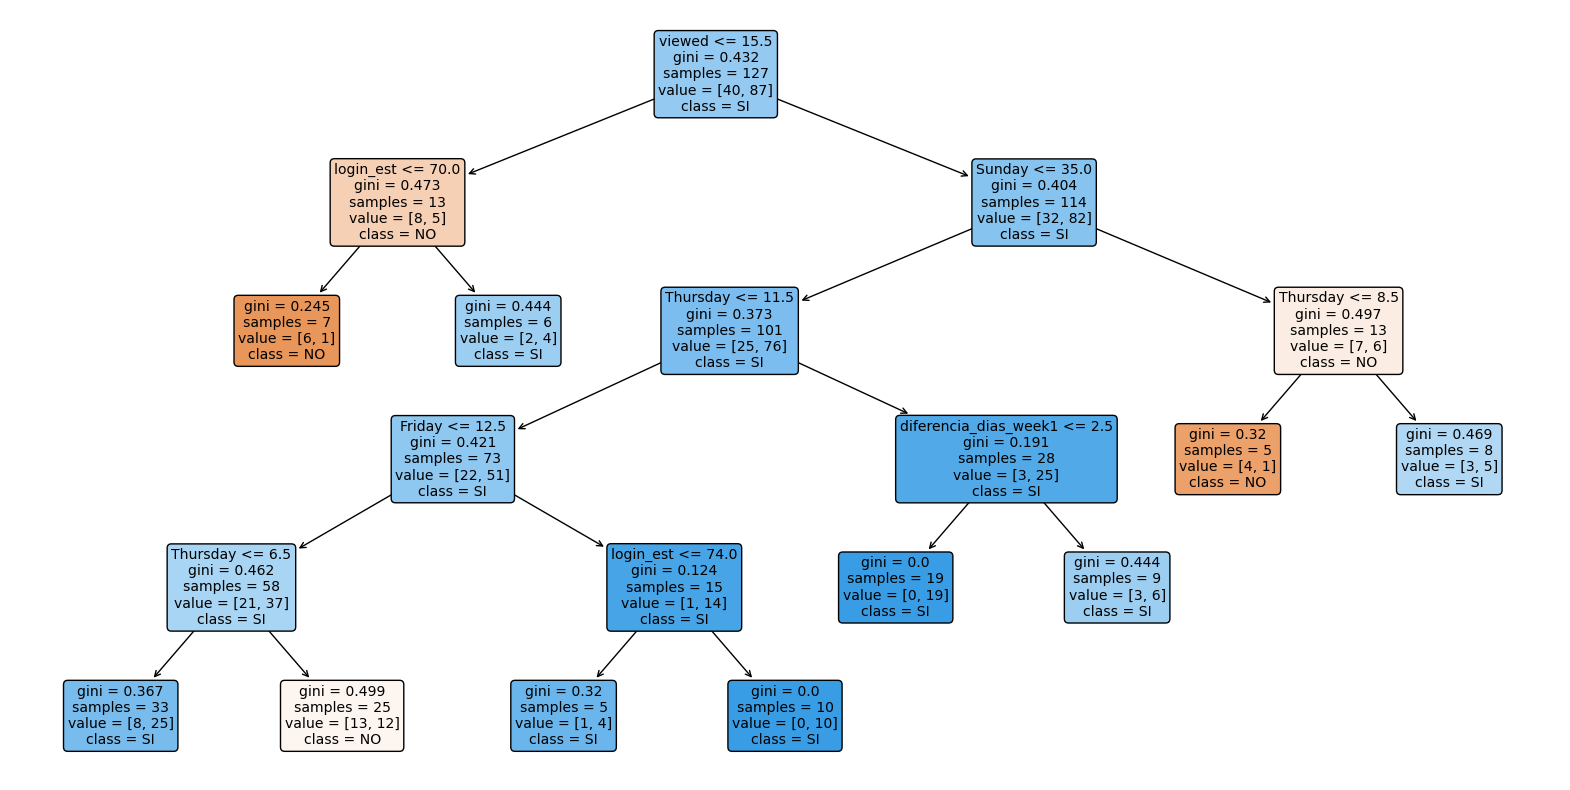

In [97]:
#Se muestra el árbol de decisión
plt.figure(figsize=(20,10))
plot_tree(decision_tree, filled=True, feature_names=X_train.columns, class_names=["NO", "SI"], rounded=True)
plt.show()

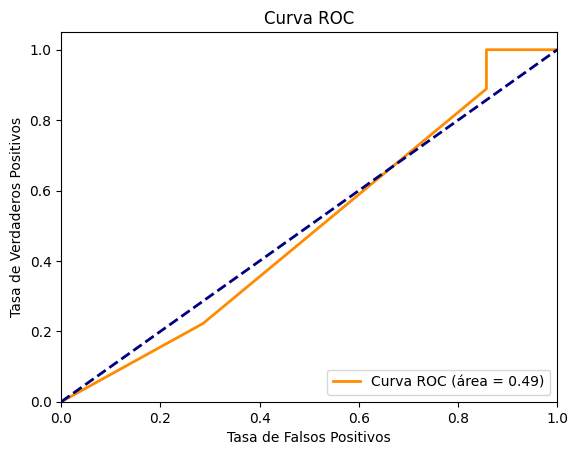

In [98]:
#Se calculan las probabilidades de la curva ROC para calcular la curva ROC y el AUC
y_pred_proba = decision_tree.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

#Se muestra la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (área = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

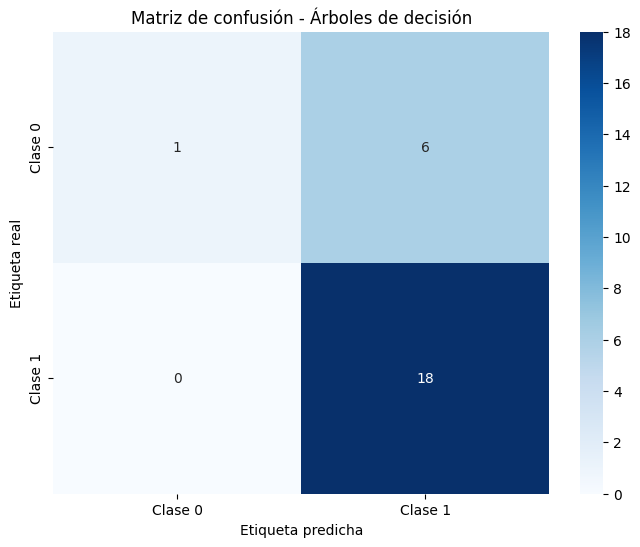

In [99]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.xlabel('Etiqueta predicha')
plt.ylabel('Etiqueta real')
plt.title('Matriz de confusión - Árboles de decisión')
plt.show()

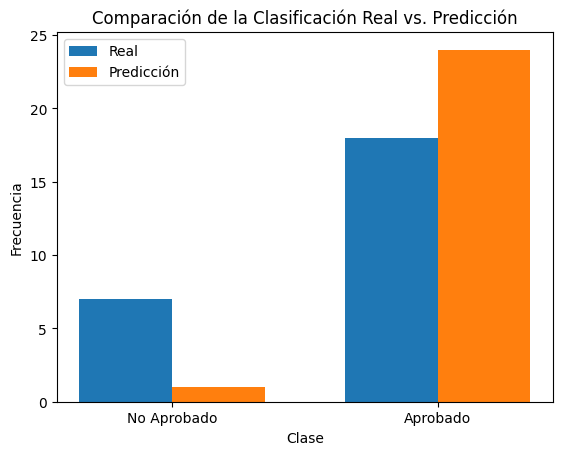

In [100]:
#Calculamos las frecuencias de las clases en los datos reales y predichos
real_class_counts = np.bincount(y_test)
predicted_class_counts = np.bincount(y_pred)

#Nos aseguramos que los vectores tienen la misma longitud
max_length = max(len(real_class_counts), len(predicted_class_counts))
real_class_counts = np.pad(real_class_counts, (0, max_length - len(real_class_counts)), 'constant')
predicted_class_counts = np.pad(predicted_class_counts, (0, max_length - len(predicted_class_counts)), 'constant')
class_labels = ['No Aprobado', 'Aprobado']

#Creación del diagrama de barras para la visualización de los datos
fig, ax = plt.subplots()
bar_width = 0.35
index = np.arange(len(class_labels))
bar1 = ax.bar(index, real_class_counts, bar_width, label='Real')
bar2 = ax.bar(index + bar_width, predicted_class_counts, bar_width, label='Predicción')
ax.set_xlabel('Clase')
ax.set_ylabel('Frecuencia')
ax.set_title('Comparación de la Clasificación Real vs. Predicción')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(class_labels)
ax.legend()

plt.show()

In [101]:
#Comparación de y_test y y_pred
df_results = pd.concat([y_test, pd.Series(y_pred)], axis = 1)
df_results.rename(columns={'nota_final_aprobado':'y_test', 0:'y_pred'}, inplace=True)
df_results

,y_test,y_pred
0,0,1
1,1,1
2,1,1
3,0,1
4,0,1
5,1,1
6,0,1
7,0,1
8,0,0
9,1,1
